Import Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import cv2
import os

Define path

In [14]:
dataset_path = 'D:\MTP\ptbdb\\'
data = open('D:\MTP\ptbdb\RECORDS.txt', 'r')

Define init values

In [15]:
records = 549          # total records
num_leads = 12         # 12 leads out of given 15 to be choosen
sampling_freq = 1000   # 1000 Hz
images_required = 15000 # from each class
each_lead_time = 2.5   # 2.5 seconds
mov_avg_filt = 50      # mov avg filter
# display_factor = 1.5  # to scale the image
# line_width = 1.5
images_per_record = 20000 ############################

In [16]:
# input the data from the ptb dataset
from read_ptb_data import read_data

fields = read_data(data=data, dataset_path=dataset_path, 
                            M=mov_avg_filt, each_lead_time=each_lead_time,
                            num_leads=num_leads, 
                            images_per_record=images_per_record,
                            scale = 4)               # call fn to read PTB db
sampling_freq = fields[0]['fs']

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

In [3]:
# load the saved data
new_path = 'D:\MTP\work\oct 6\Final_codes\data_folder'
data = np.load(new_path+'\\'+'data1.npy')
label = np.load(new_path+'\\'+'label1.npy')
for i in range(2,54):
    data_temp = np.load(new_path+'\\'+f'data{i}.npy')
    label_temp = np.load(new_path+'\\'+f'label{i}.npy')
    data = np.append(data, data_temp, axis=0)
    label = np.append(label, label_temp, axis=0)

In [4]:
print(np.shape(data))
print(np.shape(label))

(29759, 625, 12)
(29759,)


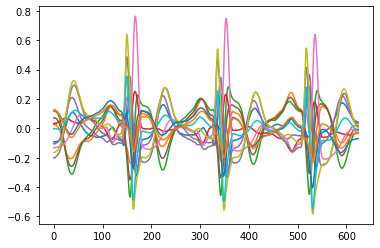

In [16]:
plt.plot(range(len(data[0,:,0])), data[0])
plt.show()

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, label, test_size = 0.2) 

In [9]:
def residual_network_1d(input_shape = (441,12)):
    n_feature_maps = 64
    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(1, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_AUC', factor=0.1, 
                                                 patience=1, verbose=1, mode='max',
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [10]:
input_shape = np.shape(train_X[0])
model = residual_network_1d(input_shape)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 625, 12)]    0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 625, 64)      6208        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 625, 64)      256         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 625, 64)      0           batch_normalization_12[0][0]     
_______________________________________________________________________________________

In [22]:
tf.keras.utils.plot_model(model, 'dnn.jpg', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
batchsize = 30
# model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=100, steps_per_epoch=(len(order_array)/batchsize), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), validation_freq=1, class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])
model.fit(x=train_X, y=train_y, epochs=100, #steps_per_epoch=(len(signals)/batchsize), 
          validation_split=0.2, #validation_freq=1, 
          callbacks=[reduce_lr,early_stop])

Epoch 1/100
 63/596 [==>...........................] - ETA: 13:39 - loss: 0.0000e+00 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - AUC: 0.0000e+00

KeyboardInterrupt: 

Storing the resultant into signals and fields.

In [ ]:
c1, c2 = 0,0
for patient in range(len(fields)):
    if(fields[patient]['comments'][4] == 'Reason for admission: Myocardial infarction'):        
        c1+=1
    elif(fields[patient]['comments'][4] == 'Reason for admission: Healthy control'):
        c2+=1
print(c1, '\n', c2)

In [ ]:
new_path = './data_folder'
if not os.path.exists(new_path):
    os.makedirs(new_path)

np.save(new_path+'/'+'data', signals)
np.save(new_path+'/'+'label', labels)

In [10]:
# to create ecg records from ptb db
from create_images import create

create(signals, fields, 
       images_required=images_required, path='.\\', 
       display_factor=display_factor, 
       sampling_freq=sampling_freq, 
       line_color = (0,0,0),
        line_width=1.5) # call fn to create ECG graphs

ECG Graph Created


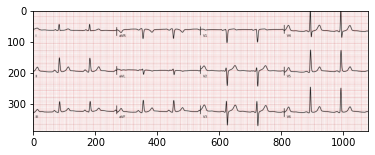

In [11]:
plt.imshow(mpimg.imread('./ptbdb/Healthy control/HC_ecg_1.jpg'))

In [12]:
# to read created ecg images
from read_images import read_img

# Resize all pics
w = 1800
h = 600
c = 3
path = './ptbdb/'

In [34]:
data, label = read_img(path=path, w=w, h=h, c=c) # call the function to read the data

ECG Images Read!!!


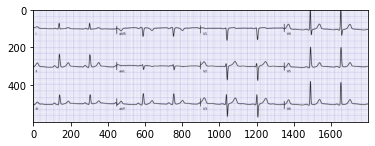

In [14]:
# after resizing and processing
plt.imshow(data[0])

In [15]:
# to convert read images to plots ie having 1D data
from image_to_plot import get_12_ecgs, graph_to_plot, moving_avg_filt

# parameters
image_intensity_threshold = 125
crop_pixels_out = 2
moving_avg_value = 3

In [16]:
# call above three functions
data_recovered = []
for i in range(len(data)):
    ecg_images_extracted = get_12_ecgs(data[i], 
                                       thresh=image_intensity_threshold, 
                                       crop=crop_pixels_out)
    
    raw_data = graph_to_plot(ecg_images_extracted)
    
    data_recovered += [moving_avg_filt(raw_data, M=moving_avg_value)]
    
data_recovered = np.array(data_recovered)
print("ECG images converted to plot data...Done")

ECG images converted to plot data...Done


### Binary Image of one ECG Lead

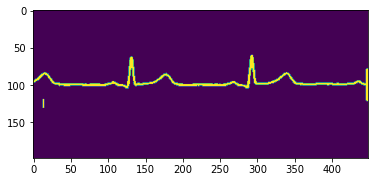

In [35]:
patient_k = 10
ecg_images_extracted = get_12_ecgs(data[patient_k], 
                                   thresh=image_intensity_threshold, 
                                   crop=crop_pixels_out)
plt.imshow(ecg_images_extracted[0])
plt.savefig(path+'/ecg.jpg')

### Raw ECG Plot

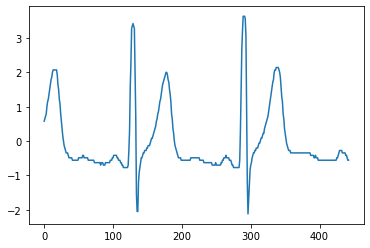

In [36]:
raw_data = graph_to_plot(ecg_images_extracted)
plt.plot(range(len(raw_data[patient_k])), raw_data[patient_k])
plt.savefig(path+'/raw_ecg.jpg')

### Filtered ECG Plot

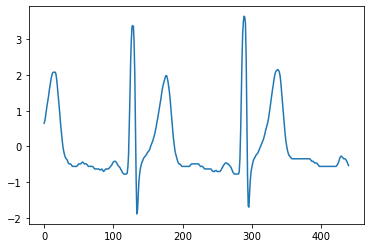

In [37]:
tempz = moving_avg_filt(raw_data, M=moving_avg_value)
plt.plot(range(len(tempz[patient_k])), tempz[patient_k])
plt.savefig(path+'/filtered_ecg.jpg')

In [20]:
del(data) # to free up memory
# save recovered data & labels in files

new_path = './data_folder'
if not os.path.exists(new_path):
    os.makedirs(new_path)

np.save(new_path+'/'+'data', data_recovered)
np.save(new_path+'/'+'label', label)

In [2]:
# load the saved data
new_path = './data_folder'
data_recovered = np.load(new_path+'/'+'data.npy')
label = np.load(new_path+'/'+'label.npy')

(50, 12, 441)

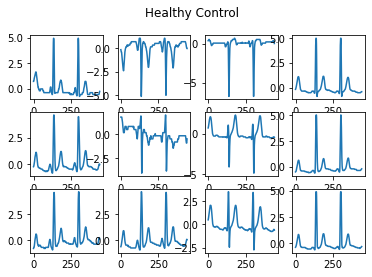

In [22]:
# Plot graph of recovered signals of jth record
j = 0
plt.figure()
if label[j]:
    plt.suptitle("Myocardial infarction")
else:
    plt.suptitle("Healthy Control")
for leads in range(num_leads):         
    plt.subplot(3, 4, leads+1)
    plt.plot(range(len(data_recovered[j, leads])), data_recovered[j, leads])
    
plt.ioff()
plt.savefig(new_path+'/'+'ecg_out.jpg')
plt.show()    

In [23]:
# read recovered data and convert it to proper format for signals
signals = np.transpose(data_recovered, axes=(0, 2, 1))
new_sampling_freq = int(np.shape(data_recovered)[2]/(each_lead_time))
sampling_freq = new_sampling_freq

Show plot of one record

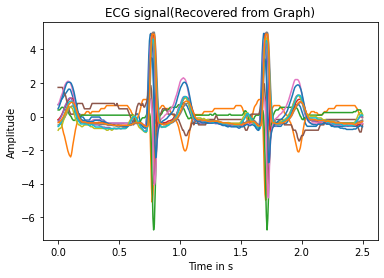

In [24]:
#%% Plot the graph of all 12 ECG signals of jth patient record number
j = 0
t = np.arange(0, (len(signals[j])/sampling_freq), (1/ sampling_freq))
plt.plot(t, signals[j])
plt.title("ECG signal(Recovered from Graph)")
plt.xlabel("Time in s")
plt.ylabel("Amplitude")
plt.ioff()
plt.savefig(new_path+'/'+'filtered_ecg_out.jpg')
plt.show()  

Performing 6 level wavelet decomposition using db9 wavelet

In [25]:
import pywt
from biorth_wavelet import custom_wavelet
dec_levels = 6         # decomposition levels
wave = custom_wavelet()

records = len(signals)
coeff = []

for patient in range(records):
    coeff += [pywt.wavedec(signals[patient], 
                           wavelet = wave, 
                           mode = 'zero', 
                           level = dec_levels, 
                           axis = 0)]

C:\ProgramData\Anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Plotting the subband coeff for jth record

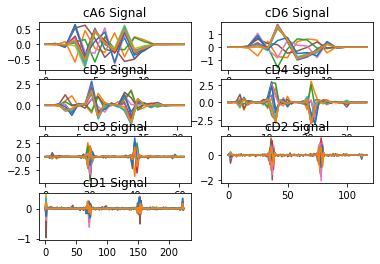

In [26]:
j = 0
c = coeff[j]
plt.figure(1)

for i in range(7):
    plt.subplot(4,2,i+1)
    t = np.arange(0, len(c[i]), 1)
    plt.plot(t, c[i])
    if i==0:
        plt.title("cA6 Signal")
    else:
        plt.title(f"cD{7-i} Signal")
        
plt.ioff()
plt.savefig(new_path+'/'+'filtered_ecg_out.jpg')
plt.show()

Calculate energy vectors for each record, we choose 4 subbands * 12 ecg leads => 48 long vector
Normalize this energy vector

Get eigen values of covariance matrix of 4 subband coefficient and find principal eigen values (we choose 6 values) => 24 long eigen vector

Concatenate the two vectors to get 72 length vector

In [27]:
from z_feature_vector import find_Z_feature
max_eig_values = 6     # top 6 eigen values to be taken of cov matrix of 4 subbands coeff
max_dec_levels = 4     # 4 subbands choosen cA6 cD6 cD5 cD4

# Get feature matrix by 48 energy values and 24 eigen values
Z = find_Z_feature(coeff, 
                   max_dec_levels=max_dec_levels, 
                   max_eig_values=max_eig_values,
                   num_leads=num_leads)

Apply 5 fold CV and clasifiers KNN, linear SVM, rbf SVM

In [28]:
#%% Apply 5 fold CV and clasifiers KNN, linear SVM, rbf SVM
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores_knn = []
scores_linear = []
scores_rbf = []

neigh = KNeighborsClassifier(n_neighbors = 5)
svc_linear = SVC(kernel = 'linear', C=30.0)
#svc_rbf = SVC(kernel = 'rbf')

#svc_linear = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
svc_rbf = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', C=30.0))

cv = KFold(n_splits = 5, shuffle = True)

for train_index, test_index in cv.split(Z):
    X_train, X_test, y_train, y_test = Z[train_index], Z[test_index], label[train_index], label[test_index]
    
    # train classifiers    
    neigh.fit(X_train, y_train)
    scores_knn.append(neigh.score(X_test, y_test))
    
    svc_linear.fit(X_train, y_train)
    scores_linear.append(svc_linear.score(X_test, y_test))
    
    svc_rbf.fit(X_train, y_train)
    scores_rbf.append(svc_rbf.score(X_test, y_test))

# print avg scores  
print('KNN mean accuracy: ',np.mean(scores_knn))
print('Linear SVM mean accuracy: ',np.mean(scores_linear))
print('RBF SVM mean accuracy: ',np.mean(scores_rbf))

KNN mean accuracy:  0.7399999999999999
Linear SVM mean accuracy:  0.8800000000000001
RBF SVM mean accuracy:  0.8


Print Classification report & Confusion Matrix

KNN Report & Confusion Matrix
              precision    recall  f1-score   support

          HC       0.83      0.83      0.83         6
          MI       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



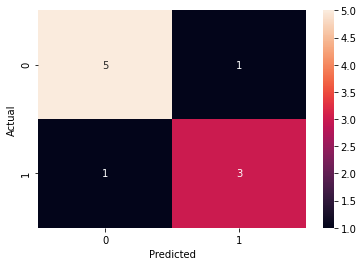

Linear SVM Report & Confusion Matrix
              precision    recall  f1-score   support

          HC       1.00      0.83      0.91         6
          MI       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



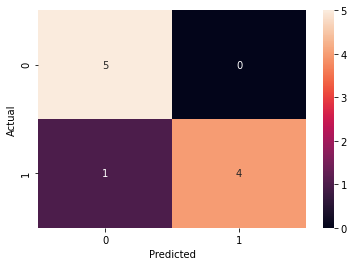

RBF SVM Report & Confusion Matrix
              precision    recall  f1-score   support

          HC       1.00      0.67      0.80         6
          MI       0.67      1.00      0.80         4

    accuracy                           0.80        10
   macro avg       0.83      0.83      0.80        10
weighted avg       0.87      0.80      0.80        10



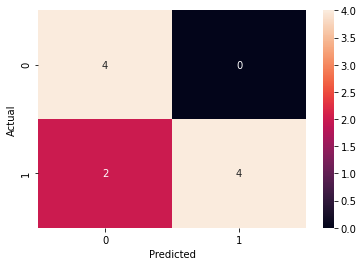

In [29]:
import seaborn as sn
from sklearn.metrics import classification_report

y_pred_KNN = neigh.predict(X_test)
y_pred_lsvc = svc_linear.predict(X_test)
y_pred_rsvc = svc_rbf.predict(X_test)

# function to create report and confusion matrix

def report_n_conf_mat(y_pred, y_test, file_name='Report.csv'):
    target_names = ['HC','MI']
    print(classification_report(y_test, y_pred, target_names=target_names))
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    report = pd.DataFrame(report).transpose()
    report.to_csv(file_name)
    
    data = {'y_Actual':    y_pred,
            'y_Predicted': y_test}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

print("KNN Report & Confusion Matrix")
report_n_conf_mat(y_pred_KNN, y_test, file_name=new_path+'/'+'KNN Classification Report.csv')


print("Linear SVM Report & Confusion Matrix")
report_n_conf_mat(y_pred_lsvc, y_test, file_name=new_path+'/'+'Linear SVM Classification Report.csv')

print("RBF SVM Report & Confusion Matrix")
report_n_conf_mat(y_pred_rsvc, y_test, file_name=new_path+'/'+'RBF SVM Classification Report.csv')


In [30]:
np.shape(data_recovered)

(50, 12, 441)

In [31]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_recovered, label, test_size = 0.2) 

In [32]:
from DNN import call
import tensorflow as tf

default_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10)

call(train_X, train_y, test_X, test_y, optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"], 
    epochs=60, batch_size=128, callbacks=default_callback, rb1=True, rb2=False, rb3=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/60
1/1 [==============================] - 2s 2s/step - loss: 8.5777 - accuracy: 0.4375 - val_loss: 3.8123 - val_accuracy: 0.7500
Epoch 2/60
1/1 [==============================] - 0s 47ms/step - loss: 8.5777 - accuracy: 0.4375 - val_loss: 3.8123 - val_accuracy: 0.7500
Epoch 3/60
1/1 [==============================] - 0s 38ms/step - loss: 8.5777 - accuracy: 0.4375 - val_loss: 3.8123 - val_accuracy: 0.7500
Epoch 4/60
1/1 [==============================] - 0s 47ms/step - loss: 8.5777 - accuracy: 0.4375 - val_loss: 3.8123 - val_accuracy: 0.7500
Epoch 5/60
1/1 [==============================] - 0s 31ms/step - loss: 8.5777 - accuracy: 0.4375 - val_loss: 3.8123 - val_accuracy: 0.7500
Epoch 6/60
1/1 [==============================] - 0s 47ms/step - loss: 8.5777 - accuracy: 0.4375 - val_loss: 3.8123 - val_accuracy: 0.7500
Epoch 7/60
1/1 [====

In [34]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.Input((b,c)),
    layers.Conv1D(32, 11, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv1D(32, 5, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(32, 11, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv1D(32, 5, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
#     layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='softmax')
    ])
#%%
# model.summary()
# #%%
# from tensorflow.keras.losses import CategoricalCrossentropy
# model.compile(optimizer='adam', 
#               loss=CategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])
# history = model.fit(train_ds, validation_data=val_ds, epochs=3)



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_X.reshape(-1,b,c), train_y, validation_split=0.2, epochs=20, 
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3))

#%%
test_loss, test_acc = model.evaluate(test_X.reshape(-1,b,c),  test_y, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/20
1/1 [==============================] - 0s 264ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 42ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 34ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 35ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
1/1 - 0s - loss: 1.0986 - accuracy: 0.4000

Test accuracy: 0.4000000059604645
